# **Lab 5: Machine Learning Library (MLlib)**

Lecturer: `Sirasit Lochanachit`


Course: `06026213 Big Data Systems`

Term: `02/2024`

Lab materials prepared by `Titipa Eamsiriwong (TA)`

**OBJECTIVES** :
*   เรียนรู้วิธีการเตรียมข้อมูล (Data Preprocessing) ด้วย Apache Spark MLlib
*   สร้าง Machine Learning Model ด้วย MLlib
*   ประเมินผลการทำงานของโมเดล (Model Evaluation)
*   ทดลองใช้งานอัลกอริธึมที่หลากหลาย

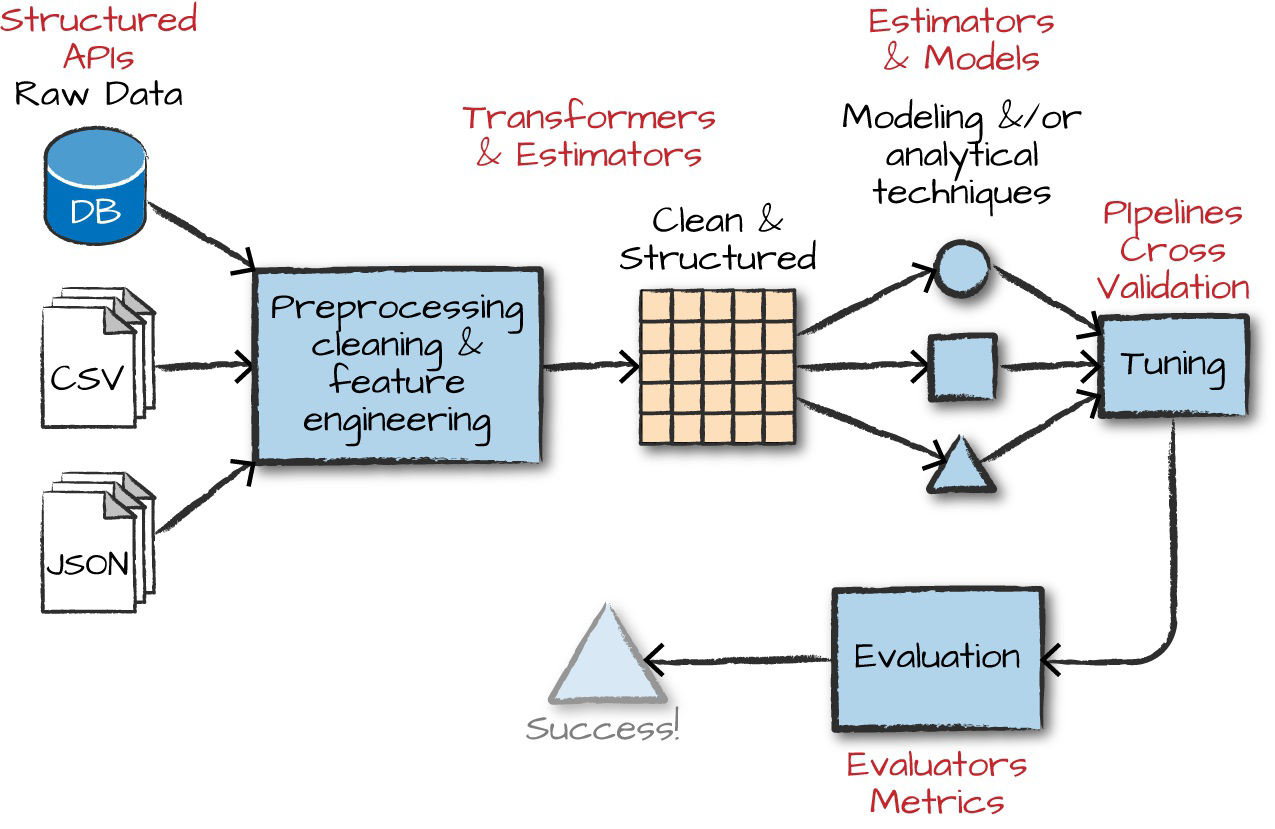

---
# **ENVIRONMENT SETUP**

> `Pipeline` ใน PySpark คือเครื่องมือที่ช่วยจัดการกระบวนการทำงานของ ML Model ให้อยู่ในลำดับขั้นตอนที่ต่อเนื่อง และมีการทำงานร่วมกันแบบอัตโนมัติ

> `MulticlassClassificationEvaluator` เป็นเครื่องมือใน PySpark ที่ใช้ในการประเมินว่าโมเดลประเภท Classifier ทำงานได้ดีแค่ไหน



In [1]:
import warnings
warnings.filterwarnings("ignore")

from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

---
# **STEP 1: Data Preprocessing**

In [3]:
spark = SparkSession.builder.getOrCreate()

## **1.1 Loading data**

ให้นักศึกษาดาวน์โหลดไฟล์หรือ Add shortcut to Drive แล้วบันทึกลงบน My Drive ของบัญชีที่เชื่อมต่อกับ Google Colab Notebook ปัจจุบัน

> [Iris.csv](https://drive.google.com/file/d/11NIbMTYlVpqK-5fIvnyVm_ao4OCUjhoo/view?usp=sharing)
>
> [weatherHistory.csv](https://drive.google.com/file/d/1Atm5kJzW2qD-4O4AgFuy1b2sVqciUlmF/view?usp=sharing)


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### iris dataset

In [4]:
schema_iris = "Id INT, SepalLengthCm DOUBLE, SepalWidthCm DOUBLE, PetalLengthCm DOUBLE, PetalWidthCm DOUBLE, Species STRING"

In [5]:
data_iris = spark.read.csv("/content/drive/MyDrive/bigDataSystems/Iris.csv", header=True, schema=schema_iris)

In [6]:
data_iris.show(3)

+---+-------------+------------+-------------+------------+-----------+
| Id|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|    Species|
+---+-------------+------------+-------------+------------+-----------+
|  1|          5.1|         3.5|          1.4|         0.2|Iris-setosa|
|  2|          4.9|         3.0|          1.4|         0.2|Iris-setosa|
|  3|          4.7|         3.2|          1.3|         0.2|Iris-setosa|
+---+-------------+------------+-------------+------------+-----------+
only showing top 3 rows



In [7]:
data_iris.count()

150

In [8]:
data_iris.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- SepalLengthCm: double (nullable = true)
 |-- SepalWidthCm: double (nullable = true)
 |-- PetalLengthCm: double (nullable = true)
 |-- PetalWidthCm: double (nullable = true)
 |-- Species: string (nullable = true)



### census dataset

In [10]:
data_census = spark.read.csv('/content/drive/MyDrive/bigDataSystems/census-income-all.csv',
                    header=True, inferSchema=True)

In [11]:
data_census.show(3)

+---+-----------------+------+----------+-------+-------------------+------------------+--------------+------+-----+------------+------------+--------------+--------------+-----+
|age|        workclass|weight| education|edu num|     marital status|        occupation|  relationship|  race|  sex|captial-gain|capital-loss|hours-per-week|native country|label|
+---+-----------------+------+----------+-------+-------------------+------------------+--------------+------+-----+------------+------------+--------------+--------------+-----+
| 39|        State-gov| 77516| Bachelors|     13|      Never-married|      Adm-clerical| Not-in-family| White| Male|        2174|           0|            40| United-States|   No|
| 50| Self-emp-not-inc| 83311| Bachelors|     13| Married-civ-spouse|   Exec-managerial|       Husband| White| Male|           0|           0|            13| United-States|   No|
| 38|          Private|215646|   HS-grad|      9|           Divorced| Handlers-cleaners| Not-in-family| W

In [12]:
data_census.count()

48842

In [13]:
data_census.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- weight: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- edu num: integer (nullable = true)
 |-- marital status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- captial-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native country: string (nullable = true)
 |-- label: string (nullable = true)



### weather dataset

In [14]:
schema_weather = "`Formatted Date` TIMESTAMP, `Summary` STRING, `Precip Type` STRING, `Temperature (C)` DOUBLE, \
                  `Apparent Temperature (C)` DOUBLE, `Humidity` DOUBLE, `Wind Speed (km/h)` DOUBLE,\
                  `Wind Bearing (degrees)` DOUBLE,`Visibility (km)` DOUBLE, `Loud Cover` DOUBLE, \
                  `Pressure (millibars)` DOUBLE, `Daily Summary` STRING"

In [15]:
data_weather = spark.read.csv("/content/drive/MyDrive/bigDataSystems/weatherHistory.csv", header=True, schema=schema_weather)

In [16]:
data_weather.show(5)

+-------------------+-------------+-----------+-----------------+------------------------+--------+------------------+----------------------+------------------+----------+--------------------+--------------------+
|     Formatted Date|      Summary|Precip Type|  Temperature (C)|Apparent Temperature (C)|Humidity| Wind Speed (km/h)|Wind Bearing (degrees)|   Visibility (km)|Loud Cover|Pressure (millibars)|       Daily Summary|
+-------------------+-------------+-----------+-----------------+------------------------+--------+------------------+----------------------+------------------+----------+--------------------+--------------------+
|2006-03-31 22:00:00|Partly Cloudy|       rain|9.472222222222221|      7.3888888888888875|    0.89|           14.1197|                 251.0|15.826300000000002|       0.0|             1015.13|Partly cloudy thr...|
|2006-03-31 23:00:00|Partly Cloudy|       rain|9.355555555555558|       7.227777777777776|    0.86|           14.2646|                 259.0|15.

In [17]:
data_weather.count()

96453

In [18]:
data_weather.printSchema()

root
 |-- Formatted Date: timestamp (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Precip Type: string (nullable = true)
 |-- Temperature (C): double (nullable = true)
 |-- Apparent Temperature (C): double (nullable = true)
 |-- Humidity: double (nullable = true)
 |-- Wind Speed (km/h): double (nullable = true)
 |-- Wind Bearing (degrees): double (nullable = true)
 |-- Visibility (km): double (nullable = true)
 |-- Loud Cover: double (nullable = true)
 |-- Pressure (millibars): double (nullable = true)
 |-- Daily Summary: string (nullable = true)



## **1.2 Feature Engineering**

In [19]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

### census dataset

In [20]:
data_census.columns

['age',
 'workclass',
 'weight',
 'education',
 'edu num',
 'marital status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'captial-gain',
 'capital-loss',
 'hours-per-week',
 'native country',
 'label']

In [21]:
data_census.select("label").show()

+-----+
|label|
+-----+
|   No|
|   No|
|   No|
|   No|
|   No|
|   No|
|   No|
|  Yes|
|  Yes|
|  Yes|
|  Yes|
|  Yes|
|   No|
|   No|
|  Yes|
|   No|
|   No|
|   No|
|   No|
|  Yes|
+-----+
only showing top 20 rows



In [22]:
data_census.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|   No|37155|
|  Yes|11687|
+-----+-----+



**Label index**
- Column ที่เป็น label ต้องมีค่าเป็น 0/1 ไม่สามารถเป็น string เช่น Yes/No ได้
- หรือใช้ StringIndexer เปลี่ยนตัวอักษรที่เป็นหมวดหมู่ให้เป็นตัวเลข
- กำหนดวิธีระบุลำดับของตัวเลขได้ผ่าน stringOrderType พารามิเตอร์
  - frequencyDesc: เรียงลำดับหมวดหมู่ตามจำนวนครั้งจากมากไปน้อย
ให้ตัวเลข 0,1,2,...
  - frequencyAsc: เรียงลำดับหมวดหมู่ตามจำนวนครั้งจากน้อยไปมาก
  - alphabetDesc: เรียงลำดับหมวดหมู่ตามตัวอักษรจากมากไปน้อย
  - alphabetAsc: เรียงลำดับหมวดหมู่ตามตัวอักษรน้อยไปมาก

In [23]:
indexer_census = StringIndexer(inputCol='label', outputCol='label_idx', stringOrderType='frequencyDesc')

In [24]:
assembler_census = VectorAssembler(inputCols=["age", 'edu num', 'captial-gain', 'capital-loss', 'hours-per-week'],
                                   outputCol='features')

### iris dataset

In [25]:
# Convert 'species' column to numerical using StringIndexer
indexer_iris = StringIndexer(inputCol="Species", outputCol="label")

In [26]:
assembler_iris = VectorAssembler(inputCols=["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"], outputCol="features")

---
# **STEP 2 : Machine Learning Models**



In [27]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

## **2.1 Binary Classification**

In [28]:
# indexer_census.fit (StringIndexer -> Estimator) -> indexer_census.transform (Transformer -> DataFrame)
data_census_indexed = indexer_census.fit(data_census).transform(data_census)
data_census_indexed.show()

+---+-----------------+------+-------------+-------+--------------------+------------------+--------------+-------------------+-------+------------+------------+--------------+--------------+-----+---------+
|age|        workclass|weight|    education|edu num|      marital status|        occupation|  relationship|               race|    sex|captial-gain|capital-loss|hours-per-week|native country|label|label_idx|
+---+-----------------+------+-------------+-------+--------------------+------------------+--------------+-------------------+-------+------------+------------+--------------+--------------+-----+---------+
| 39|        State-gov| 77516|    Bachelors|     13|       Never-married|      Adm-clerical| Not-in-family|              White|   Male|        2174|           0|            40| United-States|   No|      0.0|
| 50| Self-emp-not-inc| 83311|    Bachelors|     13|  Married-civ-spouse|   Exec-managerial|       Husband|              White|   Male|           0|           0|       

In [40]:
data_census_assembled = assembler_census.transform(data_census_indexed)
data_census_assembled.show()

+---+-----------------+------+-------------+-------+--------------------+------------------+--------------+-------------------+-------+------------+------------+--------------+--------------+-----+---------+--------------------+
|age|        workclass|weight|    education|edu num|      marital status|        occupation|  relationship|               race|    sex|captial-gain|capital-loss|hours-per-week|native country|label|label_idx|            features|
+---+-----------------+------+-------------+-------+--------------------+------------------+--------------+-------------------+-------+------------+------------+--------------+--------------+-----+---------+--------------------+
| 39|        State-gov| 77516|    Bachelors|     13|       Never-married|      Adm-clerical| Not-in-family|              White|   Male|        2174|           0|            40| United-States|   No|      0.0|[39.0,13.0,2174.0...|
| 50| Self-emp-not-inc| 83311|    Bachelors|     13|  Married-civ-spouse|   Exec-man

### Split train-test

In [41]:
(trainingData_census, testData_census) = data_census_assembled.randomSplit([0.7, 0.3],
                                                                           seed=100)

### Train model

In [45]:
lr_census = LogisticRegression(featuresCol='features', labelCol="label_idx",
                               maxIter=10,
                               regParam=0.01,
                               elasticNetParam=0.4)

In [46]:
lr_census.explainParams()

"aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)\nelasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.4)\nfamily: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)\nfeaturesCol: features column name. (default: features, current: features)\nfitIntercept: whether to fit an intercept term. (default: True)\nlabelCol: label column name. (default: label, current: label_idx)\nlowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)\nlowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound con

In [47]:
model_census = lr_census.fit(trainingData_census)

In [48]:
model_census.coefficients

DenseVector([0.0379, 0.2869, 0.0002, 0.0005, 0.0346])

In [49]:
model_census.intercept

-7.34865217524868

In [50]:
predictions_census = model_census.transform(testData_census)

In [51]:
predictions_census.show()

+---+---------+------+-------------+-------+--------------+----------+---------------+-------------------+-------+------------+------------+--------------+--------------+-----+---------+--------------------+--------------------+--------------------+----------+
|age|workclass|weight|    education|edu num|marital status|occupation|   relationship|               race|    sex|captial-gain|capital-loss|hours-per-week|native country|label|label_idx|            features|       rawPrediction|         probability|prediction|
+---+---------+------+-------------+-------+--------------+----------+---------------+-------------------+-------+------------+------------+--------------+--------------+-----+---------+--------------------+--------------------+--------------------+----------+
| 17|        ?| 34505|         11th|      7| Never-married|         ?|      Own-child|              White|   Male|           0|           0|            50| United-States|   No|      0.0|[17.0,7.0,0.0,0.0...|[2.9676005

### Model Summary

In [52]:
trainingSummary = model_census.summary
trainingSummary

In [53]:
trainingSummary.roc.show()

+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|                 0.0|0.001462522851919...|
|                 0.0|0.002803168799512492|
|                 0.0|0.004265691651432...|
|                 0.0|0.005728214503351615|
|                 0.0|0.007190737355271176|
|                 0.0|0.008531383302864107|
|                 0.0|0.009872029250457038|
|                 0.0|0.011212675198049969|
|                 0.0| 0.01267519804996953|
|                 0.0|0.014137720901889092|
|                 0.0|0.015722120658135285|
|                 0.0|0.017062766605728214|
|                 0.0|0.018525289457647774|
|                 0.0|0.019865935405240707|
|                 0.0|0.021328458257160267|
|7.688759034291866E-5|0.022425350396099938|
|1.153313855143779...| 0.02364411943936624|
|1.153313855143779...|0.024984765386959172|
|1.153313855143779...|  0.026325

In [54]:
trainingSummary.areaUnderROC

0.8256896315514808

In [55]:
trainingSummary.accuracy

0.8081363065143058

Returns precision for each label (category)

In [56]:
trainingSummary.precisionByLabel

[0.820094150179412, 0.7135416666666666]

Returns recall for each label (category)

In [57]:
trainingSummary.recallByLabel

[0.9577118253113948, 0.3339427178549665]

### Model Evaluation

In [58]:
census_test_result = model_census.evaluate(testData_census)

In [59]:
census_test_result.accuracy

0.814017094017094

In [60]:
census_test_result.precisionByLabel

[0.823886795354918, 0.7348951911220715]

In [61]:
census_test_result.recallByLabel

[0.9614107511442161, 0.3423319931074095]

## **2.2 Multiclass Classification w/ Multinomial Logistic Regression**

> ใช้สำหรับทำนายหมวดหมู่ (Categorical values) เช่น การทำนายชนิดของดอกไม้ (Iris-setosa, Iris-versicolor, Iris-virginica) หรือการจำแนกอีเมลว่าเป็น Spam / Not Spam



In [62]:
data_iris_indexed = indexer_iris.fit(data_iris).transform(data_iris)

data_iris_indexed.sample(10/150).show() # 0.0667

+---+-------------+------------+-------------+------------+---------------+-----+
| Id|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|        Species|label|
+---+-------------+------------+-------------+------------+---------------+-----+
| 10|          4.9|         3.1|          1.5|         0.1|    Iris-setosa|  0.0|
| 13|          4.8|         3.0|          1.4|         0.1|    Iris-setosa|  0.0|
| 16|          5.7|         4.4|          1.5|         0.4|    Iris-setosa|  0.0|
| 47|          5.1|         3.8|          1.6|         0.2|    Iris-setosa|  0.0|
| 90|          5.5|         2.5|          4.0|         1.3|Iris-versicolor|  1.0|
| 99|          5.1|         2.5|          3.0|         1.1|Iris-versicolor|  1.0|
|108|          7.3|         2.9|          6.3|         1.8| Iris-virginica|  2.0|
|119|          7.7|         2.6|          6.9|         2.3| Iris-virginica|  2.0|
|124|          6.3|         2.7|          4.9|         1.8| Iris-virginica|  2.0|
|150|          5

### Label

Iris-setosa = 0

Iris-versicolor = 1

Iris-virginica = 2

In [64]:
data_iris_indexed.select('label').distinct().show()

+-----+
|label|
+-----+
|  0.0|
|  1.0|
|  2.0|
+-----+



In [65]:
data_iris_assembled = assembler_iris.transform(data_iris_indexed)

data_iris_assembled.show(3)

+---+-------------+------------+-------------+------------+-----------+-----+-----------------+
| Id|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|    Species|label|         features|
+---+-------------+------------+-------------+------------+-----------+-----+-----------------+
|  1|          5.1|         3.5|          1.4|         0.2|Iris-setosa|  0.0|[5.1,3.5,1.4,0.2]|
|  2|          4.9|         3.0|          1.4|         0.2|Iris-setosa|  0.0|[4.9,3.0,1.4,0.2]|
|  3|          4.7|         3.2|          1.3|         0.2|Iris-setosa|  0.0|[4.7,3.2,1.3,0.2]|
+---+-------------+------------+-------------+------------+-----------+-----+-----------------+
only showing top 3 rows



### Split train-test

In [66]:
(trainingData_iris, testData_iris) = data_iris_assembled.randomSplit([0.7, 0.3],
                                                                     seed=100)

### Train model

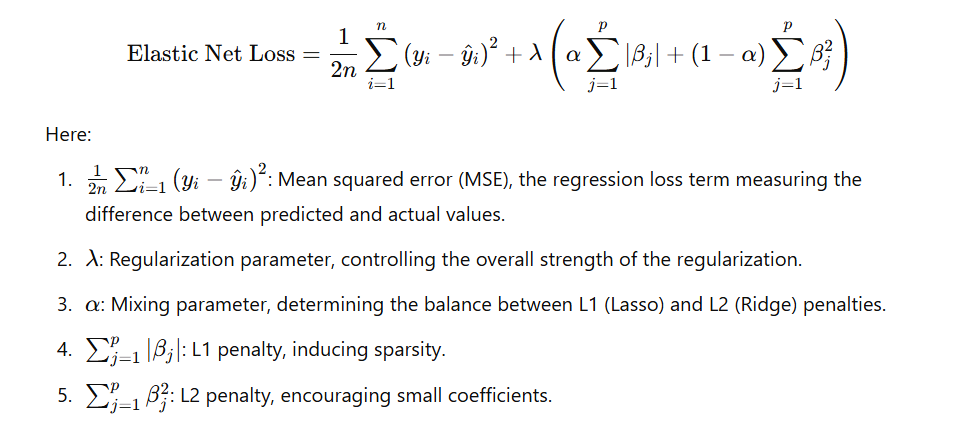

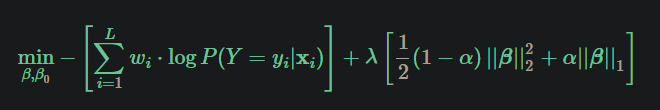

Multinomial logistic regression models for multiclass classification with elastic net regularization.

elasticNetParam corresponds to `α`
 and regParam corresponds to `λ`

In [67]:
lr = LogisticRegression(featuresCol='features', labelCol="label",
                        maxIter=10,
                        regParam=0.01,
                        elasticNetParam=0.4)

In [68]:
lr.explainParams()

"aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)\nelasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.4)\nfamily: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)\nfeaturesCol: features column name. (default: features, current: features)\nfitIntercept: whether to fit an intercept term. (default: True)\nlabelCol: label column name. (default: label, current: label)\nlowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)\nlowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constra

In [70]:
model = lr.fit(trainingData_iris)

In [71]:
model.extractParamMap()

{Param(parent='LogisticRegression_3036711bc489', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LogisticRegression_3036711bc489', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.4,
 Param(parent='LogisticRegression_3036711bc489', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto',
 Param(parent='LogisticRegression_3036711bc489', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LogisticRegression_3036711bc489', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LogisticRegression_3036711bc489', name='labelCol', doc='label column name.'): 'label',
 Param(parent='LogisticRegression_3036711bc489', name='maxBlockSizeInMB', doc='maximum memory in MB for s

In [72]:
model.coefficientMatrix

DenseMatrix(3, 4, [-1.0295, 2.8401, -0.9849, -2.0907, 0.5391, -0.8662, -0.005, -0.7927, 0.2768, -1.6306, 1.1837, 3.5899], 1)

In [74]:
model.interceptVector

DenseVector([3.5366, 2.8394, -6.3761])

In [75]:
predictions = model.transform(testData_iris)

In [76]:
predictions.show()

+---+-------------+------------+-------------+------------+---------------+-----+-----------------+--------------------+--------------------+----------+
| Id|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|        Species|label|         features|       rawPrediction|         probability|prediction|
+---+-------------+------------+-------------+------------+---------------+-----+-----------------+--------------------+--------------------+----------+
|  4|          4.6|         3.1|          1.5|         0.2|    Iris-setosa|  0.0|[4.6,3.1,1.5,0.2]|[5.70962643481717...|[0.96235592552549...|       0.0|
| 11|          5.4|         3.7|          1.5|         0.2|    Iris-setosa|  0.0|[5.4,3.7,1.5,0.2]|[6.59006774267401...|[0.98537149713711...|       0.0|
| 12|          4.8|         3.4|          1.6|         0.2|    Iris-setosa|  0.0|[4.8,3.4,1.6,0.2]|[6.25725898249172...|[0.98094836444387...|       0.0|
| 15|          5.8|         4.0|          1.2|         0.2|    Iris-setosa|  0.0|[

In [77]:
result = predictions.select("features", "label", "probability", "prediction").collect()
result

[Row(features=DenseVector([4.6, 3.1, 1.5, 0.2]), label=0.0, probability=DenseVector([0.9624, 0.0376, 0.0]), prediction=0.0),
 Row(features=DenseVector([5.4, 3.7, 1.5, 0.2]), label=0.0, probability=DenseVector([0.9854, 0.0146, 0.0]), prediction=0.0),
 Row(features=DenseVector([4.8, 3.4, 1.6, 0.2]), label=0.0, probability=DenseVector([0.9809, 0.0191, 0.0]), prediction=0.0),
 Row(features=DenseVector([5.8, 4.0, 1.2, 0.2]), label=0.0, probability=DenseVector([0.9932, 0.0068, 0.0]), prediction=0.0),
 Row(features=DenseVector([5.7, 4.4, 1.5, 0.4]), label=0.0, probability=DenseVector([0.9977, 0.0023, 0.0]), prediction=0.0),
 Row(features=DenseVector([5.1, 3.8, 1.5, 0.3]), label=0.0, probability=DenseVector([0.9928, 0.0072, 0.0]), prediction=0.0),
 Row(features=DenseVector([5.4, 3.4, 1.7, 0.2]), label=0.0, probability=DenseVector([0.948, 0.052, 0.0]), prediction=0.0),
 Row(features=DenseVector([5.0, 3.0, 1.6, 0.2]), label=0.0, probability=DenseVector([0.8952, 0.1048, 0.0]), prediction=0.0),
 R

In [78]:
for row in result:
    print("features=%s, label=%s -> prob=%s, prediction=%s" % (row.features, row.label, row.probability, row.prediction))

features=[4.6,3.1,1.5,0.2], label=0.0 -> prob=[0.9623559255254978,0.03764257797351206,1.4965009901641323e-06], prediction=0.0
features=[5.4,3.7,1.5,0.2], label=0.0 -> prob=[0.9853714971371134,0.01462820485558018,2.980073065810461e-07], prediction=0.0
features=[4.8,3.4,1.6,0.2], label=0.0 -> prob=[0.9809483644438765,0.01905099205484821,6.435012753567942e-07], prediction=0.0
features=[5.8,4.0,1.2,0.2], label=0.0 -> prob=[0.9932298132249711,0.006770117658847767,6.9116181125304e-08], prediction=0.0
features=[5.7,4.4,1.5,0.4], label=0.0 -> prob=[0.9977038176155915,0.0022961215549137715,6.082949481389764e-08], prediction=0.0
features=[5.1,3.8,1.5,0.3], label=0.0 -> prob=[0.9927642215159564,0.007235549487947612,2.2899609589065577e-07], prediction=0.0
features=[5.4,3.4,1.7,0.2], label=0.0 -> prob=[0.9479542849267523,0.05204402364793094,1.6914253168100948e-06], prediction=0.0
features=[5.0,3.0,1.6,0.2], label=0.0 -> prob=[0.8952126468386729,0.10478279354319825,4.559618129052547e-06], prediction

### Model evaluation

In [79]:
eval = model.evaluate(testData_iris)

In [80]:
eval.accuracy

0.9782608695652174

In [81]:
eval.precisionByLabel

[1.0, 0.9285714285714286, 1.0]

In [83]:
evaluator = MulticlassClassificationEvaluator(labelCol="label",
                                              predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
accuracy

0.9782608695652174

In [84]:
evaluator.explainParams()

'beta: The beta value used in weightedFMeasure|fMeasureByLabel. Must be > 0. The default value is 1. (default: 1.0)\neps: log-loss is undefined for p=0 or p=1, so probabilities are clipped to max(eps, min(1 - eps, p)). Must be in range (0, 0.5). The default value is 1e-15. (default: 1e-15)\nlabelCol: label column name. (default: label, current: label)\nmetricLabel: The class whose metric will be computed in truePositiveRateByLabel|falsePositiveRateByLabel|precisionByLabel|recallByLabel|fMeasureByLabel. Must be >= 0. The default value is 0. (default: 0.0)\nmetricName: metric name in evaluation (f1|accuracy|weightedPrecision|weightedRecall|weightedTruePositiveRate| weightedFalsePositiveRate|weightedFMeasure|truePositiveRateByLabel| falsePositiveRateByLabel|precisionByLabel|recallByLabel|fMeasureByLabel| logLoss|hammingLoss) (default: f1, current: accuracy)\npredictionCol: prediction column name. (default: prediction, current: prediction)\nprobabilityCol: Column name for predicted class c

In [85]:
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label",
                                              predictionCol="prediction",
                                              metricName="precisionByLabel")
precision = evaluator_precision.evaluate(predictions)
precision

1.0

## **2.3 Linear Regression**


In [86]:
data_weather.show()

+-------------------+-------------+-----------+------------------+------------------------+--------+------------------+----------------------+------------------+----------+--------------------+--------------------+
|     Formatted Date|      Summary|Precip Type|   Temperature (C)|Apparent Temperature (C)|Humidity| Wind Speed (km/h)|Wind Bearing (degrees)|   Visibility (km)|Loud Cover|Pressure (millibars)|       Daily Summary|
+-------------------+-------------+-----------+------------------+------------------------+--------+------------------+----------------------+------------------+----------+--------------------+--------------------+
|2006-03-31 22:00:00|Partly Cloudy|       rain| 9.472222222222221|      7.3888888888888875|    0.89|           14.1197|                 251.0|15.826300000000002|       0.0|             1015.13|Partly cloudy thr...|
|2006-03-31 23:00:00|Partly Cloudy|       rain| 9.355555555555558|       7.227777777777776|    0.86|           14.2646|                 259.

In [90]:
from pyspark.ml.regression import LinearRegression

weather_assembler = VectorAssembler(inputCols=['Humidity',
                                               'Wind Speed (km/h)',
                                               'Visibility (km)'],
                                    outputCol='features')
data_weather_assembled = weather_assembler.transform(data_weather)

In [91]:
train_data, test_data = data_weather_assembled.randomSplit([0.8, 0.2],
                                                           seed=100)

In [93]:
linearR = LinearRegression(featuresCol='features',
                           labelCol='Temperature (C)')
model = linearR.fit(train_data)
predictions = model.transform(test_data)

In [94]:
# Show some predictions
predictions.select("prediction", "Temperature (C)", "features").show(5)

+------------------+------------------+--------------------+
|        prediction|   Temperature (C)|            features|
+------------------+------------------+--------------------+
|  8.53812969452865|1.7111111111111101| [0.82,14.49,9.9015]|
| 6.876086483095772|2.7888888888888905|[0.83,21.6062,9.9...|
| 9.961660044901635| 7.438888888888889|[0.72,24.8423,11....|
| 7.781219152707546| 5.972222222222222|[0.8,24.230500000...|
|3.7995624062706383|2.3499999999999983|[0.91,15.29500000...|
+------------------+------------------+--------------------+
only showing top 5 rows



In [95]:
error = model.evaluate(test_data)

error.rootMeanSquaredError, error.meanAbsoluteError

(7.055624929120722, 5.6897468412417815)

## **STEP 3: Model Selection (Hyperparameter tuning)**

In [96]:
pipeline = Pipeline(stages=[indexer_iris, assembler_iris, lr])

In [97]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [98]:
paramGrid = ParamGridBuilder().addGrid(lr.regParam,
 [0.1, 0.01]).addGrid(lr.elasticNetParam,
  [0.0, 0.5, 1.0]).build()

paramGrid

[{Param(parent='LogisticRegression_3036711bc489', name='regParam', doc='regularization parameter (>= 0).'): 0.1,
  Param(parent='LogisticRegression_3036711bc489', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0},
 {Param(parent='LogisticRegression_3036711bc489', name='regParam', doc='regularization parameter (>= 0).'): 0.1,
  Param(parent='LogisticRegression_3036711bc489', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5},
 {Param(parent='LogisticRegression_3036711bc489', name='regParam', doc='regularization parameter (>= 0).'): 0.1,
  Param(parent='LogisticRegression_3036711bc489', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 1.0},
 {Pa

In [100]:
# CrossValidator is Estimator

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=5)

In [104]:
crossval.explainParams()

"collectSubModels: Param for whether to collect a list of sub-models trained during tuning. If set to false, then only the single best sub-model will be available after fitting. If set to true, then all sub-models will be available. Warning: For large models, collecting all sub-models can cause OOMs on the Spark driver. (default: False)\nestimator: estimator to be cross-validated (current: Pipeline_4a82b2df4c28)\nestimatorParamMaps: estimator param maps (current: [{Param(parent='LogisticRegression_3036711bc489', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='LogisticRegression_3036711bc489', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}, {Param(parent='LogisticRegression_3036711bc489', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='LogisticRegression_3036711bc489', name='elasticNetParam', doc='the ElasticNe

In [99]:
# split train-test from raw data that not process by feature engineering

train_Data_iris, test_Data_iris = data_iris.randomSplit([0.7,0.3],seed=100)

In [101]:
model = crossval.fit(train_Data_iris)

In [105]:
model.extractParamMap()

{Param(parent='CrossValidatorModel_ecf167472a00', name='seed', doc='random seed.'): 6417663303067525006,
 Param(parent='CrossValidatorModel_ecf167472a00', name='numFolds', doc='number of folds for cross validation'): 5,
 Param(parent='CrossValidatorModel_ecf167472a00', name='foldCol', doc="Param for the column name of user specified fold number. Once this is specified, :py:class:`CrossValidator` won't do random k-fold split. Note that this column should be integer type with range [0, numFolds) and Spark will throw exception on out-of-range fold numbers."): '',
 Param(parent='CrossValidatorModel_ecf167472a00', name='estimator', doc='estimator to be cross-validated'): Pipeline_4a82b2df4c28,
 Param(parent='CrossValidatorModel_ecf167472a00', name='estimatorParamMaps', doc='estimator param maps'): [{Param(parent='LogisticRegression_3036711bc489', name='regParam', doc='regularization parameter (>= 0).'): 0.1,
   Param(parent='LogisticRegression_3036711bc489', name='elasticNetParam', doc='the

In [108]:
predictions = model.transform(test_Data_iris)
predictions

DataFrame[Id: int, SepalLengthCm: double, SepalWidthCm: double, PetalLengthCm: double, PetalWidthCm: double, Species: string, label: double, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [109]:
predictions.show(3)

+---+-------------+------------+-------------+------------+-----------+-----+-----------------+--------------------+--------------------+----------+
| Id|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|    Species|label|         features|       rawPrediction|         probability|prediction|
+---+-------------+------------+-------------+------------+-----------+-----+-----------------+--------------------+--------------------+----------+
|  4|          4.6|         3.1|          1.5|         0.2|Iris-setosa|  1.0|[4.6,3.1,1.5,0.2]|[4.30167037735578...|[0.01720735014282...|       1.0|
| 11|          5.4|         3.7|          1.5|         0.2|Iris-setosa|  1.0|[5.4,3.7,1.5,0.2]|[4.61451234444133...|[0.00855517226537...|       1.0|
| 12|          4.8|         3.4|          1.6|         0.2|Iris-setosa|  1.0|[4.8,3.4,1.6,0.2]|[4.37988086912717...|[0.01075232069766...|       1.0|
+---+-------------+------------+-------------+------------+-----------+-----+-----------------+-----------

In [112]:
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label",
                                                       predictionCol="prediction",
                                                       metricName="accuracy")
accuracy = evaluator_accuracy.evaluate(predictions)
accuracy

0.9565217391304348